In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import xml.etree.ElementTree as ET
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
def parse_xml(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        filename = root.find('filename').text
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        coords = {
            'xmin': int(bbox.find('xmin').text),
            'ymin': int(bbox.find('ymin').text),
            'xmax': int(bbox.find('xmax').text),
            'ymax': int(bbox.find('ymax').text)
        }
        annotations.append({'filename': filename, 'label': label, 'bbox': coords})
    return annotations

In [3]:
ANNOTATION_PATH = 'dataset/annotations'
xml_files = [os.path.join(ANNOTATION_PATH, filename) for filename in os.listdir(ANNOTATION_PATH)]

data = []
for xml_file in xml_files:
    annotations = parse_xml(xml_file)

    for annotation in annotations:
        data.append([annotation['filename'], annotation['label'], annotation['bbox']])

df = pd.DataFrame(data, columns=['filename', 'label', 'bbox'])
df['label'].value_counts()

label
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64

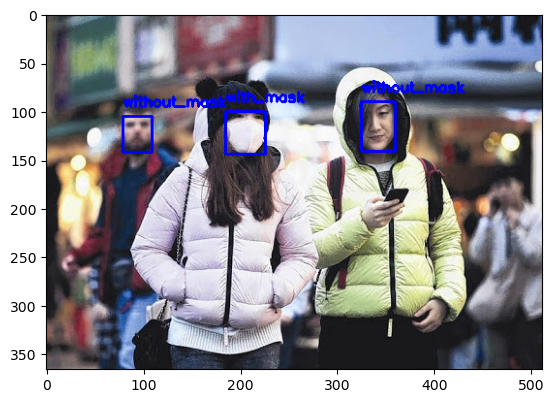

In [4]:
def visualize_annotation(image_path, annotations):
    image = cv2.imread(image_path)

    for ann in annotations:
        bbox = ann['bbox']
        cv2.rectangle(image, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), (255, 0, 0), 2)
        cv2.putText(image, ann['label'], (bbox['xmin'], bbox['ymin'] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
visualize_annotation('dataset/images/maksssksksss0.png', parse_xml('dataset/annotations/maksssksksss0.xml'))

In [5]:
from tqdm import tqdm

IMAGE_PATH = 'dataset/images/'
label_pair = {
    'with_mask': 0,
    'without_mask': 1,
    'mask_weared_incorrect': 2
}

face_images = []
face_labels = []

for i in tqdm(range(len(df)), desc='Image Extraction: '):
    row = df.iloc[i]
    bbox = row['bbox']
    image = cv2.imread(IMAGE_PATH + row['filename'])
    image = image[bbox['ymin']:bbox['ymax'], bbox['xmin']:bbox['xmax']]
    image = cv2.resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    face_images.append(image)
    face_labels.append(label_pair[row['label']])

Image Extraction: 100%|█████████████████████████████████████████████████████████████████████████| 4072/4072 [00:56<00:00, 72.67it/s]


In [6]:
data = np.array(face_images, dtype="float32")
labels = np.array(face_labels)

trainX, testX, trainY, testY = train_test_split(
    data, labels,
	test_size=0.20,
    stratify=labels,
    random_state=42
)

In [7]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest"
)


In [8]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(
    weights="imagenet",
    include_top=False,
	input_tensor=Input(shape=(224, 224, 3))
)

# construct the head of the model that will be placed on top of the ===the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [9]:
# loop over all layers in the base model and freeze them so they will *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [10]:
# initialize the initial learning rate, number of epochs to train for, and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [11]:
# compile our model
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=opt,
	metrics=["accuracy"]
)

In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

es = EarlyStopping(
    patience=3,
	monitor='val_accuracy',
	restore_best_weights=True
)

lr = ReduceLROnPlateau(
    monitor='val_loss',
	patience=2,
	factor=0.5,
	verbose=1
)

In [13]:
# train the head of the network
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS,
    callbacks=[es, lr]
)

Epoch 1/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7148 - loss: 0.7826 - val_accuracy: 0.8748 - val_loss: 0.3838 - learning_rate: 1.0000e-04
Epoch 2/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 0.9062 - loss: 0.4391 - val_accuracy: 0.8761 - val_loss: 0.3812 - learning_rate: 1.0000e-04
Epoch 3/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.8138 - loss: 0.4838 - val_accuracy: 0.9018 - val_loss: 0.3220 - learning_rate: 1.0000e-04
Epoch 4/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 0.8750 - loss: 0.4235 - val_accuracy: 0.9018 - val_loss: 0.3214 - learning_rate: 1.0000e-04
Epoch 5/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.8629 - loss: 0.3954 - val_accuracy: 0.9055 - val_loss: 0.3075 - learning_rate: 1.0000e-04
Epoch 6/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - accuracy: 0.7500 - loss: 0.4236 - val_accuracy: 0.9043 - val_loss: 0.3087 - learning_rate: 1.0000e-04
Epoch 7/20
101/101 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step

In [14]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 802ms/step


In [15]:
# show a nicely formatted classification report
print(classification_report(
    testY,
    predIdxs,
	target_names=label_pair.keys()
))

                       precision    recall  f1-score   support

            with_mask       0.93      0.97      0.95       647
         without_mask       0.81      0.81      0.81       143
mask_weared_incorrect       1.00      0.08      0.15        25

             accuracy                           0.91       815
            macro avg       0.92      0.62      0.64       815
         weighted avg       0.91      0.91      0.90       815



In [16]:
# serialize the model to disk
model.save("mask_detector.keras")

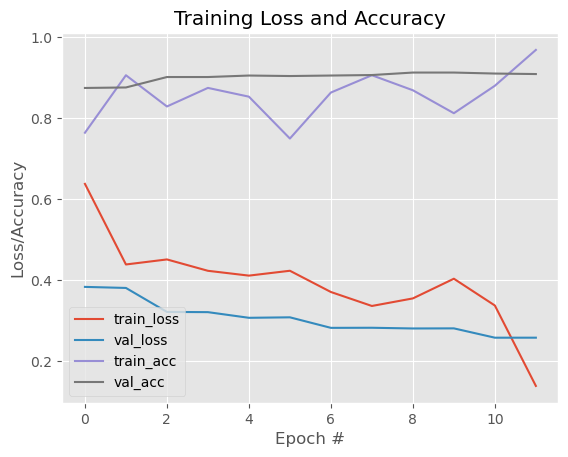

In [22]:
# plot the training loss and accuracy
N = len(H.history['accuracy'])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")